In [1]:
%run Latex_macros.ipynb
%run beautify_plots.py

<IPython.core.display.Latex object>

$$
\newcommand{\o}{\mathbf{o}}
$$


In [2]:
# My standard magic !  You will see this in almost all my notebooks.

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

# Reload all modules imported with %aimport
%load_ext autoreload
%autoreload 1
%matplotlib inline

In [3]:
# Standard imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Common imports
import os

import decision_trees_helper as dthelp
%aimport decision_trees_helper

th = dthelp.TitanicHelper()

import mnist_helper
%aimport mnist_helper

mnh = mnist_helper.MNIST_Helper()

import class_helper
%aimport class_helper

clh= class_helper.Classification_Helper()

import training_models_helper as tmh
%aimport training_models_helper

tm = tmh.TrainingModelsHelper()

import decision_trees_helper as dthelp
%aimport decision_trees_helper

num_head=5

In [4]:
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn import linear_model, preprocessing, model_selection 
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder, LabelEncoder
from sklearn.metrics import accuracy_score
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer 
from sklearn.base import BaseEstimator, TransformerMixin

# Overview

In this notebook we will learn about
- Categorical variables
    - non-numeric
- Classification task
    - Supervised Learning, with categorical target

We begin with the Binary Classification task, in which the targets
are one of two possible values
- Positive/Negative

# Recipe Step A: Get the data

## Frame the problem
Borrowed  from [Wikipedia](https://en.wikipedia.org/wiki/RMS_Titanic)

>RMS Titanic was a British passenger liner that sank in the North Atlantic Ocean in 1912 after the ship struck an iceberg during her maiden voyage from Southampton to New York City. Of the estimated 2,224 passengers and crew aboard, more than 1,500 died, making it one of modern history's deadliest peacetime commercial marine disasters

The goal is to predict whether a passenger survives, based on passenger characteristics.
- target: { "Survive", "Not Survive" }
- features: vector of passenger characteristics

That is: a Binary Classification Task
- Positive: "Survive"
- Negative: "Not survive"

**Aside:** What does the Titanic have to do with Finance or Risk ?
- Credit risk: will borrower default ?
- Mortgage prepayment risk: Will mortgage Prepay ?

## Recipe A.1: Get the data
The data comes in two CSV format files
- train
- test

We will read them into a Pandas DataFrame.
- Observe our use of *relative paths* for file names
- Using relative rather than absolute paths will allow us to grade your assignment on our machine
    - Files in different absolute locations, but same relative location

In [5]:
# Note the use of *relative path*; you should all use relative rather than absolute paths
TITANIC_PATH = th.TITANIC_PATH
print("Data directory: ", TITANIC_PATH)

train_data = pd.read_csv( os.path.join(TITANIC_PATH, "train.csv") )
test_data  = pd.read_csv( os.path.join(TITANIC_PATH, "test.csv")  )


Data directory:  ./data/titanic


In [6]:
train_data.shape
test_data.shape

(891, 12)

(418, 11)

## Recipe A.2: Have a look at the data
Let's examine the first few records to get a feel for the shape of the data.

This will help us understand the features and the target.

In [7]:
train_data.columns
train_data.head()

Index(['PassengerId', 'Survived', 'Pclass', 'Name', 'Sex', 'Age', 'SibSp',
       'Parch', 'Ticket', 'Fare', 'Cabin', 'Embarked'],
      dtype='object')

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


The attributes have the following meaning:
* **Survived**: that's the target
    - 0 means passenger did not survive (Negative)
    - 1 means passenger survived (Positive)
* **Pclass**: passenger class.
* **Name**, **Sex**, **Age**: self-explanatory
* **SibSp**: how many siblings & spouses of the passenger aboard the Titanic.
* **Parch**: how many children & parents of the passenger aboard the Titanic.
* **Ticket**: ticket id
* **Fare**: price paid (in pounds)
* **Cabin**: passenger's cabin number
* **Embarked**: where the passenger embarked the Titanic

How many observations are there ?


In [8]:
(num_obs, num_features) = train_data.shape
print("There are {nr} observations and {nf} attributes (including the target)".format(nr=num_obs, nf=num_features) )

There are 891 observations and 12 attributes (including the target)


Observation
- The data covers many fewer examples than the number of described in the problem statement
- Is the data not truly representative ?

We'll ignore this for now.

Let's try to understand the types of the attributes

In [9]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
PassengerId    891 non-null int64
Survived       891 non-null int64
Pclass         891 non-null int64
Name           891 non-null object
Sex            891 non-null object
Age            714 non-null float64
SibSp          891 non-null int64
Parch          891 non-null int64
Ticket         891 non-null object
Fare           891 non-null float64
Cabin          204 non-null object
Embarked       889 non-null object
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


**Non-numeric attributes**

We can see the non-numeric attributes (type is "object") are:
- `Name`
- `Sex`
- `Cabin`
- `Embarked`

**Data issues: missing attributes**

We can also see that we have some missing data issues to deal with.

Any attribute with less than num_obs values has observations with a missing value in the attribute
- `Age`
- `Cabin`
- `Embarked`

**Other issues**
- Shouldn't `Survived` be non-numeric (Positive/Negative or Survived/Not) ?
    - looks like this has been encoded as the integer 1/0
- What about `Pclass` ? Shouldn't it be non-numeric ?
    - This could have just as easily been encoded as non-numeric "First", "Second", "Third"
    - Is the fact that it has been encoded as small integers significant ?
    - This is much deeper than it sounds.
        - We will revisit when discussing Categorical variables.
        
For our first pass at the problem: we will ignore issues concerning `Survived` and `Pclass`.

Let's get a summary of the distribution of each attribute

(n.b., `describe` operates *only* on the numeric attributes)

In [10]:
train_data.describe()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000
mean,446.000000,0.383838,2.308642,29.699118,0.523008,0.381594,32.204208
std,257.353842,0.486592,0.836071,14.526497,1.102743,0.806057,49.693429
min,1.000000,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,223.500000,0.000000,2.000000,20.125000,0.000000,0.000000,7.910400
50%,446.000000,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,668.500000,1.000000,3.000000,38.000000,1.000000,0.000000,31.000000
max,891.000000,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


- You can also observe the attributes with missing values by looking at the "count"
- You can clearly see that `Survived` is a binary, *integer* variable
- Only 38 % of the passengers survived ("mean")

In [11]:
train_data["Survived"].value_counts()

0    549
1    342
Name: Survived, dtype: int64

<img src="images/Back_to_parent.jpg">

## Recipe A.3: Select a performance measure
Our performance measure for the Classification task will be **accuracy**, the fraction of correct predictions.

$$
\textrm{Accuracy} = \frac{\textrm{number of correct predictions}}{\textrm{number of predictions} }
$$

There are several drawbacks with this definition, which we will address later.

But let's start with it for now.

## Recipe A.4: Create a test set and put it aside !

The train/test split was done for us: it came as two separate files

We might later choose to combine the two and do our own split (or better yet: multiple splits) but for now, we'll take what we are given.

Note that the test set provided *does not have targets* associated with each example
- The dataset was from a Kaggle competition.  The "answers" (targets) to the test set were known only to the judges.
- This means you can't use the provided test set to evaluate the Performance Measure.  Either
    - Create your own test set
    - Use Cross Validation

<img src="images/Back_to_parent.jpg">

# Recipe Step B: Exploratory Data Analysis (EDA)

## Visualize Data to gain insights

### Distribution of each attribute

Let's start by looking at the (unconditional) distribution of the target and some attributes

First let's look at them normalized (i.e, as fractions or probabilities)

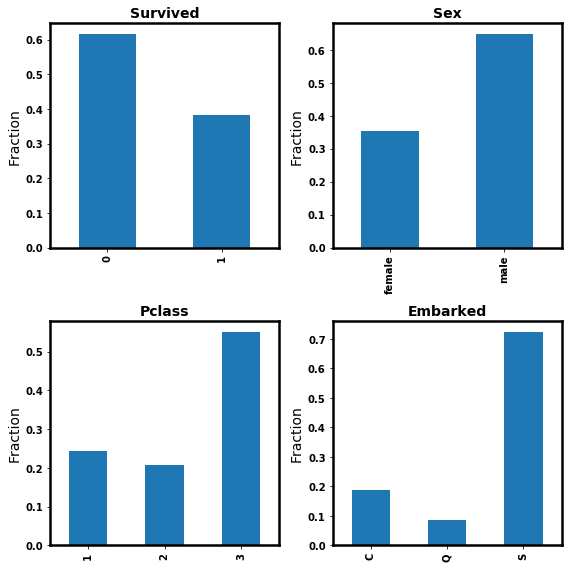

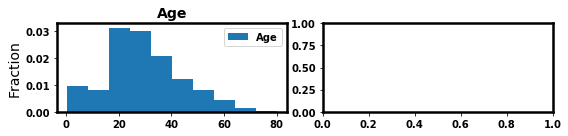

In [12]:
clh.plot_attrs(train_data, [ "Survived", "Sex", "Pclass", "Embarked" ], attr_type="Cat", plot=True, normalize=True)
clh.plot_attrs(train_data, [ "Age" ], attr_type="Num", normalize=True)

Next, let's look at them un-normalized, or absolute count

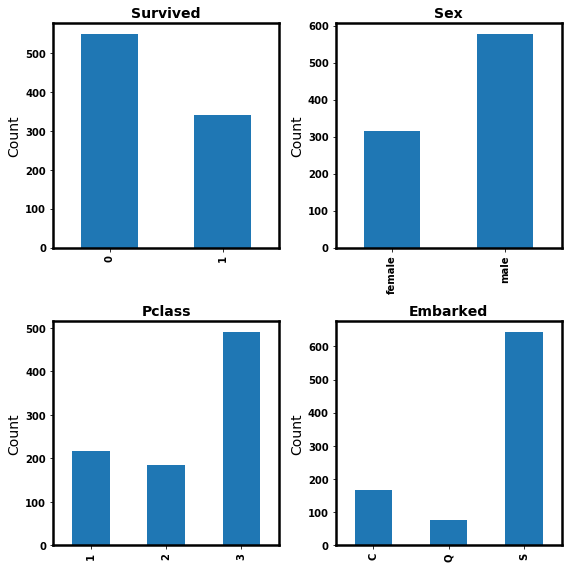

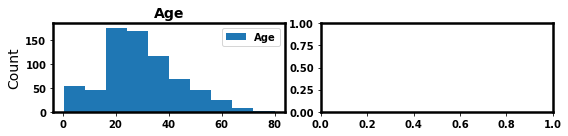

In [13]:
clh.plot_attrs(train_data, [ "Survived", "Sex", "Pclass", "Embarked" ], attr_type="Cat", plot=True, normalize=False)
clh.plot_attrs(train_data, [ "Age" ], attr_type="Num", normalize=False)

### Conditional survival probability (condition on single attribute)

Let's explore whether there is a relationship between the target (Survived) and single features
- This might tell us whether the feature has some predictive value
    - If the distribution of the target is different for each value of the feature
    - The feature may have an association with the target

In [14]:
fig, axs = clh.plot_conds(train_data, [ ("Survived", { "Sex": "female"}),
                         ("Survived", { "Sex": "male"}),
                         None,
                         ("Survived", { "Pclass": 1}),
                         ("Survived", { "Pclass": 2}),
                         ("Survived", { "Pclass": 3}),
                        
                         ("Survived", { "Embarked":"C"}),
                         ("Survived", { "Embarked":"Q"}),
                         ("Survived", { "Embarked":"S"})
                       ],
                          share_y="row",
                          normalize="False"
          )

# In case the figure is truncated in this slide, we will re-display it in the next (without the code)
plt.close(fig)

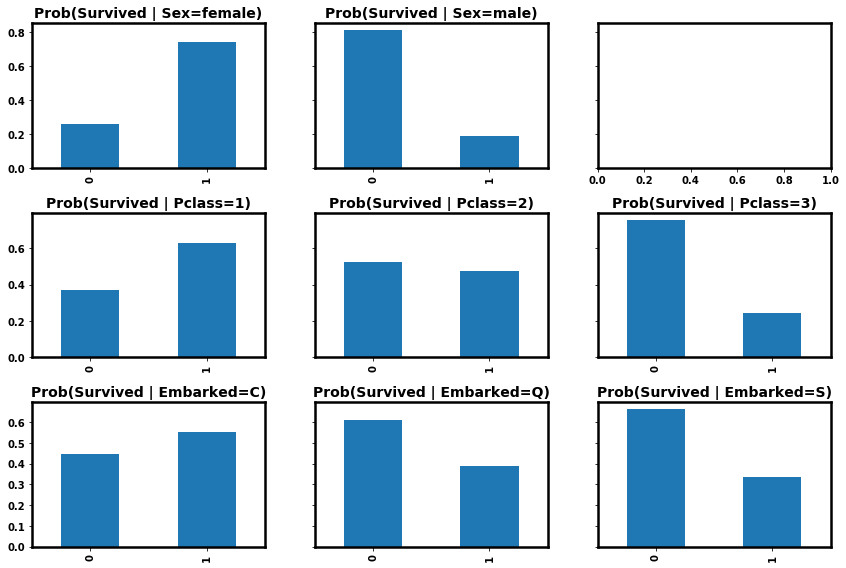

In [15]:
# Display the figure again, in it's own slide, so it is not truncated
fig

Interesting !
- Women are 3 times as likely to survive
- NOT being in the lowest Class doubles or triples your survival probability
- Embarking at Cherbourg increased your probability of surviving
    - WHY ? Is there a correlation between Class and point of embarkation maybe ?
    
Preview: There may also be lessons here for dealing with missing data

### Conditional survival probability (condition on multiple attributes)

- Having examined possible associations between the target and single features
- We now examine a possible association to pairs of features
- A single feature alone may not separate the data into different target values
- But combinations of features might

In [16]:
fig, axs = clh.plot_conds(train_data, [
                         ("Survived", { "Sex": "female", "Pclass": 1}),
                         ("Survived", { "Sex": "female", "Pclass": 2}),
                         ("Survived", { "Sex": "female", "Pclass": 3}),
    
                         ("Survived", { "Sex": "male", "Pclass": 1}),
                         ("Survived", { "Sex": "male", "Pclass": 2}),
                         ("Survived", { "Sex": "male", "Pclass": 3}),
                       ],
                          share_y="row"
                         )

# In case the figure is truncated in this slide, we will re-display it in the next (without the code)
plt.close(fig)

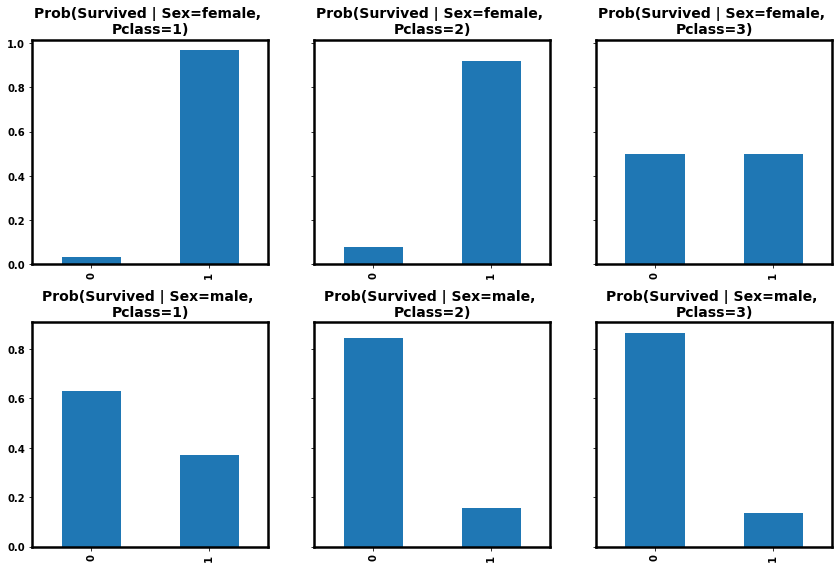

In [17]:
# Display the figure again, in it's own slide, so it is not truncated
fig

Remember our original theory that being Female *unconditionally* increased chances of Survive ?
- We can see now see that this was only true *conditionally* for Classes 1 and 2

### Aside: Using Pandas for partitioning the data

<div class="alert alert-block alert-info">
    <b>Aside</b>:   How does pd.groupby() work ?
</div>

If you examine our modules to see how we are partitioning the data
- You will see how useful the Pandas `groupby` method is
- For those who know SQL: this is similar to grouping in database queries
- For those who want to know how `groupby` works, this section explains
    - Feel free to skip it
`


The Pandas Split-Apply-Combine pattern is very powerful
- This is very SQL-like, for those who have used databases
- Below is some simpler Pandas code to show exactly how it works

In [18]:
# Partition by the attribute "Sex"
males   = train_data[ train_data["Sex"] == "male"]
females = train_data[ train_data["Sex"] == "female"]

# Aggregate within each group: count,mean.  n.b., only doing this for the "Survived" column
count_males, count_females = males.shape[0], females.shape[0]
survival_males, survival_females = males["Survived"].mean(), females["Survived"].mean()

print( "male\t{c}\t{m:0.4f}".format(c=count_males, m=survival_males) )
print( "female\t{c}\t{m:0.4f}".format(c=count_females, m=survival_females) )

# Or, use the pd.groupby
train_data.groupby("Sex").agg(["mean", "count"])["Survived"]


male	577	0.1889
female	314	0.7420


,mean,count
Sex,,
female,0.742038,314
male,0.188908,577


<img src="images/Back_to_parent.jpg">

# Recipe Step C: Prepare the data

Our first model will use the following features
- Pclass
- Sex
- Age
- SibSp: passenger's number of "same-level" relatives (Sibling, Spouse)
- Parch: passenger's number of "different-level" relatives (Parent, Child)
- Fare

We will follow all the steps for the Prepare the Data step per our Recipe.

But
- We will initially only discuss what we intend to do for each sub-step
- The actual code will be deferred to the end of this section
- We will use a single Pipeline to implement all the steps of Prepare the Data

## Recipe C.1: Cleaning

Our initial data exploration revealed some attributes with missing data
- Age
- Cabin
- Embarked

We will address various strategies for dealing with missing data in the module on Data Transformations.

For now, we will take a very simple (and naive) approach
- For numeric attributes: use the median value
- For non-numeric attributes: use the most frequent value

## Recipe C.2: Handling non-numeric features/targets

The next step in the Recipe is dealing with non-numeric variables.
- Numericalize (convert to a number) categorical variables

Mechanically: we will use a single Pipeline to accomplish several steps in the Recipe
- Data cleaning
- Converting categorical features
- Transformations

That is, we will implement Cleaning and Numericalization as types of transformers.

### Categorical Transformation: Binary variable special case

We will need to transform our categorical features into numbers.

The way to treat categorical values is not obvious and there are many *wrong* ways to do it.

Fortunately, a binary categorical variable is an easy special case.

Again: this will suffice for a first pass
- We will subsequently generalize to non-binary categorical variables.

Which variables are categorical ?

We can (and should) apply *human logic* to answer this question.

But a little code can help:

In [19]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
PassengerId    891 non-null int64
Survived       891 non-null int64
Pclass         891 non-null int64
Name           891 non-null object
Sex            891 non-null object
Age            714 non-null float64
SibSp          891 non-null int64
Parch          891 non-null int64
Ticket         891 non-null object
Fare           891 non-null float64
Cabin          204 non-null object
Embarked       889 non-null object
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


All of the columns described as `object` are non-numerical and hence likely suspects
- `Name`, `Sex`, `Cabin`, `Embarked`

We will have to numericalize `Sex` as this is the only categorical feature we retain for our initial model.

But, as observed during our first look, some numeric columns are *also* candidates
- `Survived`
- `PassengerId`, `Pclass`

This is where *human logic* comes in:
- Is there an *ordering relationship* among the values for a variable ?
- If not: it may be categorical
        

Our target `Survived` was given to us as numeric
- The categorical values Survive/Not Survive have been encoded as 1 and 0.

It will turn out that this is an adequate (although not perfect) encoding of a *binary* variable.

So, by luck (or bad encoding) we don't have to convert the categorical Survived feature to a binary digit. 

 

## Recipe C.3: Transformations

In this step we can
- Transform/filter existing features
- Add new features synthesized from raw features.

In this introduction: we will not do any further transformation.

But we will give you a taste for what might be possible.


**Cabin**

Might the Cabin location be associated with Survival ?  

Note that the front of the ship went down first.

If you are a diligent Data Scientist you can find this image, which is revealing
- Worst cabins (pink, Third class) were dispersed between front and back
- Best cabins (white, First class) were dispersed between above/below deck
- Mid cabins(yellow, Second Class) were *not* near front of ship
![Titanic cabins](images/Titanic_cabin_layout.jpg)

**Age**

For linear estimators ($\Theta^T \x$)
each increment in value of a feature impacts the prediction.

- An example with feature value $2 * \x_j$ has twice the impact of an example with feature value $\x_j$.

But is this really true ? Does even a small increment in Age (e.g, from 25 to 26 years) matter ?

We might be able to improve things using a "bucket" transformation:
- All Ages within a range (bucket)are equally important
    - Convert continuous Age into a non-numeric "Age Bucket" ("Age Bucket" as a categorical)
    - OR: convert all ages within a bucket to the same value ("Age Bucket" as an ordinal)
- Model will try to make distinctions *across* buckets, but not *within* a bucket.

We will create Age Bucket as an ordinal (there *is* a relationship between buckets based on magnitude)

In [20]:
train_data_augmented = train_data.copy()
train_data_augmented["AgeBucket"] = train_data["Age"] // 15 * 15
train_data_augmented[["AgeBucket", "Survived"]].groupby(['AgeBucket']).mean()

,Survived
AgeBucket,
0.0,0.576923
15.0,0.362745
30.0,0.423256
45.0,0.404494
60.0,0.240000
75.0,1.000000


Wow ! Children below the age of 15 (bucket 0.0) had a much better chance of survival.  

(And it doesn't pay to be old when disaster strikes!)

We would be hard pressed to see this using Age as a continuous variable

**Aside**

It would have been **far better** if we had implemented this "Age Bucket" transformation as part of a Pipeline  with all other transformations !

By not doing so, we risk making the mistake of not applying the bucketing consistently to the in-sample and out of sample examples.

- In the remainder of this lecture: we will not use Age Bucket.

- It might be instructive to learn how to implement custom transformations on your own, and use this as an example.  

- Try including your custom transformation as part of the pipeline for an improved Titanic model.

**Embarked**

The Embarked attribute tells us where the passenger boarded:
- C=Cherbourg, Q=Queenstown, S=Southampton.

Could this be a predictor of Survived ?

## Recipe C.4: Scaling

For this exercise: no scaling will be performed.

<img src="images/Back_to_parent.jpg">

# Recipe Step C in practice:  a sophisticated pipeline

We  begin by
- Eliminating training examples that don't have targets
- Removing the target column from the training data
    - To be sure we don't accidentally cheat


In [21]:
# Remove examples where target is not defined
train_data = train_data[ train_data["Survived"].notnull() ]

# Separate target from features
y_train = train_data["Survived"]
train_data.drop(columns=["Survived"], inplace=True)

We use the `sklearn` Pipeline object for
several steps in the Prepare the Data part of the Recipe .

We will have separate Pipelines for numeric and non-numeric features

## The numeric pipeline

The Pipeline for numeric features
- Selects those attributes identified as numeric (variable `num_features`)
- Performs Cleaning: 
    - Missing data imputation
    - Replacing missing value with median value of the feature

In [22]:
num_features = ["Age", "SibSp", "Parch", "Fare", "Pclass"]
num_transformers= Pipeline(steps=[  ('imputer', SimpleImputer(strategy='median')) ] )
num_pipeline = ColumnTransformer( transformers=[ ("numeric", num_transformers, num_features) ] )


The `ColumnTransformer`
- Filters the features to those in `num_features`
- Applies the numeric Pipeline
    - The single transformer ` SimpleImputer` for missing data imputation

Let's see what the numeric pipeline produces.

Note: the result is a NumPy array
- That is the type produced by the final transformer (`SimpleImputer`)


In [23]:
num_pipeline.fit_transform(train_data)[:num_head]

array([[22.    ,  1.    ,  0.    ,  7.25  ,  3.    ],
       [38.    ,  1.    ,  0.    , 71.2833,  1.    ],
       [26.    ,  0.    ,  0.    ,  7.925 ,  3.    ],
       [35.    ,  1.    ,  0.    , 53.1   ,  1.    ],
       [35.    ,  0.    ,  0.    ,  8.05  ,  3.    ]])

## The non-numeric pipeline

The Pipeline for non-numeric features
- Selects those attributes identified as Categorical (variable `cat_features`)
- Performs Cleaning
    - Missing data imputation
    - Replacing missing value with the value of the feature that occurs most often
- Performs Numericalization on feature `Sex`

One reason for separate numeric/non-numeric Pipelines is that the transformers are not identical

**WARNING**: I'm doing a little cheating in this code by ignoring all categorical features other than `Sex`

In [24]:
cat_features = ["Sex" ]
cat_transformers= Pipeline(steps=[  ('imputer', SimpleImputer(strategy="most_frequent")),
                                    ('sex_encoder', OrdinalEncoder())
                                 ] )
cat_pipeline = ColumnTransformer( transformers=[ ("categorical", cat_transformers, cat_features) ] )

Again, the `ColumnTransformer`
- Filters features to those in `cat_features`
- Applies the non-numeric pipeline
    - Transformer for missing data imputation: `SimpleImputer`
        - with a different strategy than the one for numeric features
    - Transformer for Numericalization: `OrdinalEncoder`

One reason for separate numeric and non-numeric pipelines is that they implement different transformations.

Let's see what the non-numeric pipeline produces.

In [25]:
cat_pipeline.fit_transform(train_data)[:num_head]
train_data["Sex"].head(num_head)

array([[1.],
       [0.],
       [0.],
       [0.],
       [1.]])

0      male
1    female
2    female
3    female
4      male
Name: Sex, dtype: object

## Combining the numeric and categorical pipelines: `ColumnTransformer`

We have been using `ColumnTranformer` to filter the features before applying each pipeline

We will also use it as a simple way to combine the numeric and non-numeric pipelines.

<div class="alert alert-block alert-danger">
    <b>ColumnTransformer alert:</b> 
    <ul>
    <li>Depending on what version of `sklearn` you are using, this may still be considered an "experimental" feature</li>
    <li>If that is the case: you might want to explore FeatureUnion: the "official" way of combining pipelines
        <ul>
            <li>You must manually select the features of each type</li>
            <li>Apply the corresponding Pipelines</li>
            <li>"Glue together" (horizontally) the results of the Pipelines</li>
        </ul>
    </li>  
    </ul> 
</div>


In [26]:
preprocess_pipeline = ColumnTransformer(
    transformers=[ ("numeric", num_transformers, num_features),
                   ("categorical", cat_transformers, cat_features)
                 ]
)


Let's look at the result of applying the combined `preprocess_pipeline`

In [27]:
X_train = preprocess_pipeline.fit_transform(train_data)

X_train.shape
X_train[:num_head]

# X_train is now an ndarray, so really can't discern columns, but are in same order as in Feature Union
# so first the num_features, then cat_features
# Can verify this by looking at train_data
all_features = num_features.copy()
all_features.extend(cat_features)
train_data.loc[:, all_features ] .head()

(891, 6)

array([[22.    ,  1.    ,  0.    ,  7.25  ,  3.    ,  1.    ],
       [38.    ,  1.    ,  0.    , 71.2833,  1.    ,  0.    ],
       [26.    ,  0.    ,  0.    ,  7.925 ,  3.    ,  0.    ],
       [35.    ,  1.    ,  0.    , 53.1   ,  1.    ,  0.    ],
       [35.    ,  0.    ,  0.    ,  8.05  ,  3.    ,  1.    ]])

,Age,SibSp,Parch,Fare,Pclass,Sex
0,22.0,1,0,7.2500,3,male
1,38.0,1,0,71.2833,1,female
2,26.0,0,0,7.9250,3,female
3,35.0,1,0,53.1000,1,female
4,35.0,0,0,8.0500,3,male


<img src="images/Back_to_parent.jpg">

# Recipe Step D: Train a model

OK, we have identified features and now want to predict Survived. 

How do we do it ?

## Recipe D.1:Select a model

We currently know of two models for the Classification task
- K Nearest Neighbors
- Logistic Regression

We will use Logistic Regression.

To review:
$$
\begin{array}[lll]\\
s & = & \Theta^T \x \\
\hat{p} & = & \sigma(s) \\
\end{array}
$$

$$
\hat{\y}^\ip = 
\left\{
    {
    \begin{array}{lll}
     \text{Negative} & \textrm{if } \hat{p}^\ip   < 0.5    \\
     \text{Positive} & \textrm{if } \hat{p}^\ip \ge 0.5   
    \end{array}
    }
\right.
$$


We will re-visit the choice of threshold $0.5$ at a later time.

Varying the threshold is an attempt at balancing the impact of making two different types of incorrect prediction
- False Positive: predicting Positive when the true target is Negative
- False Negative: predicting Negative when the true target is Positive

Depending on your problem, the impact of being incorrect is not the same for both cases.

## Step D.2: Fit

The prior steps in the Recipe have led us to this point
- We removed examples for which the target/label `Survived` was not defined
- We dealt with missing values for features
- We transformed the data into numeric form
- We made sure the target was separated from the features

We're ready to fit our chosen model: Logistic Regression.

### Logistic Regression classifier

Let's instantiate a `LogisticRegression` object, `sklearn`'s implementation of Logistic Regression.

In [28]:

# New version of sklearn will give a warning if you don't specify a solver (b/c the default solver -- liblinear -- will be replaced in future)
logistic_clf = linear_model.LogisticRegression(solver='liblinear')

**More models, more fun ! Same price !**

Although we have selected Logistic Regression as our model,there are other models for the Classification task.


It turns out to be just as
easy to run *multiple* models as it is one !

So, for pedantic purposes, we will fit *many* models
- To show you how easy it is
- We will not delve deeply into the other models, at least for now



**SVM Classifier**

We instantiate an object that implements a Support Vector Classifier (SVC):

In [29]:
from sklearn.svm import SVC

svm_clf = SVC(gamma="auto")

**Random Forest Classifier**

We instantiate an object that implements a Random Forest Classifier.

In [30]:
from sklearn.ensemble import RandomForestClassifier

forest_clf = RandomForestClassifier(n_estimators=100, random_state=42)

### Fit the models

We will train all the models at once.

This demonstrates the power of a consistent API: 
- Training several models is no more difficult than training one.

#### Cheating in Cross Validation

We had previously mentioned the issue of Cheating when using Cross Validation.
- Using the "out of sample" fold when fitting one of the $k$ data sets in $k$-fold Cross Validation

The following, innocuous looking piece of code shows how easy it is to fall into this trap:


In [31]:
for name, clf in { "Logistic": logistic_clf,
                   "SVM": svm_clf,
                   "Random Forest": forest_clf
                 }.items():
    
    # Transform the data
    X_train = preprocess_pipeline.fit_transform(train_data)
    _= clf.fit(X_train, y_train)
 
    # Cross validation
    scores = cross_val_score(clf, X_train, y_train, cv=10)
    print("Model: {m:s} avg cross val score={s:3.2f}\n".format(m=name, s=scores.mean()) )
       
    # Fit the model using all training data.
    #  cross_val_score does not run the fit on the complete data.
    #  It runs a number of fits, each fit being on the data with one fold held out for validation.
    _= clf.fit(X_train, y_train)


Model: Logistic avg cross val score=0.80

Model: SVM avg cross val score=0.71

Model: Random Forest avg cross val score=0.82



This is "cheating" because
- The transformation of raw features (`train_data`) into synthetic features (`X_train`)
- Used the *entire* set of training examples
- Even though each iteration of Cross Validation *did not* have one fold as part of its training examples

That is:
- `preprocess_pipeline.fit_transform(train_data)` sees the *whole* data set
- Even though `cross_val_score(clf, X_train, y_train, cv=10)` will fit a model on only 9/10 of the examples
    $10$-fold cross validation

It might be too strong to call this "cheating" but at the least we are peeking at out of sample examples.

Why is this so common ?
- It seems like a lot of coding effort to run the transformations for each iteration of Cross Validation
- It *is* cheaper to transform the raw data once, rather than $k$ times: one for each fold
- The difference between the proper and improper ways is often not significant

Fortunately, `sklearn` makes it easy to perform Cross Validation without peeking.

(Other Machine Learning toolkits may not make it as easy).

- Create a Pipeline with a classifier as the final element
- Use that Pipeline as the "model" for Cross Validation


In [32]:
for name, clf in { "Logistic": logistic_clf,
                   "SVM": svm_clf,
                   "Random Forest": forest_clf
                 }.items():
    
    # Combine the transformation pipeline with a final classification step
    model_pipeline = Pipeline(steps=[ ("transform", preprocess_pipeline),
                                      ("classify", clf)
                                    ]
                             )
    
    # Cross validation on the combined pipeline
    scores = cross_val_score(model_pipeline, train_data, y_train, cv=10)
    print("Model: {m:s} avg cross val score={s:3.2f}\n".format(m=name, s=scores.mean()) )
       
    # Fit the model using all training data.
    #  cross_val_score does not run the fit on the complete data.
    #  It runs a number of fits, each fit being on the data with one fold held out for validation.
    _= model_pipeline.fit(train_data, y_train)


Model: Logistic avg cross val score=0.80

Model: SVM avg cross val score=0.71

Model: Random Forest avg cross val score=0.82



This is a little subtle:
- The "model" that we are fitting is a Pipeline !
- The "model" performs the transformations as a first step
- `cross_val_score(model_pipeline, train_data, y_train, cv=10)`
    - Will withhold the "out of sample" fold from the initial transformation
    - No cheating !

The (average) accuracy of the various models is in the range of 70% to 80%.

The only effort involved in training and comparing 3 models was creating a loop !

There is an additional advantage to including the model as the final step of the pipeline
- It makes it easy to consistently apply the same transformation to a test example as to a training example
     - Test examples require Missing data imputation, Numericalization, etc. too
- Prediction is as simple as
    - `model_pipeline.predict(X_test)`


#### Nested Pipelines

Notice the use of nested Pipelines:
- `model_pipeline` contains Pipeline `preprocess_pipeline` as an element
- `preprocess_pipeline` contains Pipelines `num_transformers` and `cat_transformers` as elements

<img src="images/Back_to_parent.jpg">

## Recipe D.4:  Error analysis

Cross validation gives you a metric, *at an aggregate level*, of how well the model performed out of sample.

You will gain deeper insight into the Classification task by analyzing *individual* predictions.

Go through each out of sample example and determine the predicted class.

- Is there some class for which the predictions are much less successful than others ?
- Is there some identifiable commonality among examples on which mis-prediction occurred ?

This is a signal to improve your model
- Perhaps by adding features that aid prediction for the mis-classified examples or target class

There is some standard terminology for analyzing classification predictions.

For binary classification, to be concrete, let's call the two classes Positive (P) and Negative (N).

Let's create a table
- The row labels correspond to the predicted class
- The column labels correspond to the target (actual) class

In pictures:
$$
\begin{array}{lll}
\\
           & \textbf{P} &  \textbf{N} \\
\textbf{P} & \text{TP}         & \text{FP} \\
\textbf{N} & \text{FN}         & \text{TN} \\
\end{array}
$$

- The entry labeled True Positive (TP) denotes the number of  examples
    - that were correctly predicted as Positive
- The entry labeled as False Positive (FP) denotes the number of  examples
    - that were incorrectly predicted as Positive
- The entry labeled True Negative (TN) denotes the number of  examples
    - that were correctly predicted as Negative
- The entry labeled False Negative denotes the number of  examples
    - that were incorrectly predicted as Negative

So

$$\textrm{Accuracy} =  { \text{TP} + \text{TN} \over  \text{TP} + \text{FP} + \text{TN} + \text{FN} } $$

Examples that are either False Positive (FP) or False Negative (FN) are mis-predictions.

Error Analysis focuses on the examples of either type.


<img src="images/Back_to_parent.jpg">

# Titanic revisited: OHE  features

Is `Pclass` really a numeric feature just because it was presented to us as a value in $\{ 1, 2, 3 \}$ ?

We argue that it should be treated as a *categorical* feature
- Any integer ordering we could impose would also impose a magnitude that could affect the math
    - $\{ 1, 2, 3 \}$ versus $\{ 10, 20, 30 \}$

The proper way to deal with categorical variables is with One Hot Encoding.

Let's treat `Pclass` as categorical and refit our model.
- Move `Pclass` from `num_features` to `cat_features`

In [33]:
print("First model\n\tcategorical features are: {c:s}\n\tnumeric features are: {n:s}".format(
    c=", ".join(cat_features), n=", ".join(num_features))
    )

First model
	categorical features are: Sex
	numeric features are: Age, SibSp, Parch, Fare, Pclass


In [34]:
num_features = ["Age", "SibSp", "Parch", "Fare" ]
num_transformers= Pipeline(steps=[  ('imputer', SimpleImputer(strategy='median')) ] )
num_pipeline = ColumnTransformer( transformers=[ ("numeric", num_transformers, num_features) ] )

cat_features = ["Sex", "Pclass" ]
cat_transformers= Pipeline(steps=[  ('imputer', SimpleImputer(strategy="most_frequent")),
                                    ('cat_encoder', OneHotEncoder(sparse=False))
                                 ] )
cat_pipeline = ColumnTransformer( transformers=[ ("categorical", cat_transformers, cat_features) ] )

preprocess_pipeline = ColumnTransformer(
    transformers=[ ("numeric", num_transformers, num_features),
                   ("categorical", cat_transformers, cat_features)
                 ]
)

In [35]:
print("Second model\n\tcategorical features are: {c:s}\n\tnumeric features are: {n:s}".format(
    c=", ".join(cat_features), n=", ".join(num_features))
    )

Second model
	categorical features are: Sex, Pclass
	numeric features are: Age, SibSp, Parch, Fare


The `cat_pipeline` now creates $5$ indicators whereas the old one created only 1
- The `Sex`attribute is now 2 indicators ("Is Female", "Is Male") rather than the integer 0/1
- The `Pclass` attribute is now 3 indicators ("Is class 1", "Is class 2", "Is class 3")

Let's look at the first couple of training examples after OHE has been applied.

We will show the encoding along with the corresponding class labels.

In [36]:
# Run the categorial pipeline
cat_ndarray = cat_pipeline.fit_transform(train_data)

# Let's examine the first first rows of the ndarray, and relate them to the same rows in the DataFrame, 
# -- n.b., with the DataFrame, we can see the column names
num_to_see = 7

print(cat_features[0] + ":\n")
cat_ndarray[:num_to_see, :2]

train_data.loc[:, [ cat_features[0] ] ].head(num_to_see)

Sex:



array([[0., 1.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [0., 1.],
       [0., 1.],
       [0., 1.]])

,Sex
0,male
1,female
2,female
3,female
4,male
5,male
6,male


You should see that
- the Male examples (e.g., rows 0, 4) are encoded as vector $[0,1]$
- the Female examples (e.g., rows 1, 2) are encoded as vector $[1,0]$

Let's look at the encoding for `Pclass`:

In [37]:
print(cat_features[1] + ":\n")
cat_ndarray[:num_to_see, -3:]
train_data.loc[:, [ cat_features[1]]].head(num_to_see)

Pclass:



array([[0., 0., 1.],
       [1., 0., 0.],
       [0., 0., 1.],
       [1., 0., 0.],
       [0., 0., 1.],
       [0., 0., 1.],
       [1., 0., 0.]])

,Pclass
0,3
1,1
2,3
3,1
4,3
5,3
6,1


You should see that
- Class 3 (e.g., rows 0, 2) are encoded as $[0,0,1]$

Notice that $\X$ now has many more feature columns.

In [38]:
X_train = preprocess_pipeline.fit_transform(train_data)

# Note: All the columns in untransformed train_data are NOT in X_train, especially the target Survived !
train_data.columns
X_train.shape
X_train

Index(['PassengerId', 'Pclass', 'Name', 'Sex', 'Age', 'SibSp', 'Parch',
       'Ticket', 'Fare', 'Cabin', 'Embarked'],
      dtype='object')

(891, 9)

array([[22.,  1.,  0., ...,  0.,  0.,  1.],
       [38.,  1.,  0., ...,  1.,  0.,  0.],
       [26.,  0.,  0., ...,  0.,  0.,  1.],
       ...,
       [28.,  1.,  2., ...,  0.,  0.,  1.],
       [26.,  0.,  0., ...,  1.,  0.,  0.],
       [32.,  0.,  0., ...,  0.,  0.,  1.]])

What effect did the change in treatment of `Pclass` from numeric to OHE have ?

In [39]:
for name, clf in { "Logistic": logistic_clf,
                   "SVM": svm_clf,
                   "Random Forest": forest_clf
                 }.items():
    
    model_pipeline = Pipeline(steps=[ ("transform", preprocess_pipeline),
                                      ("classify", clf)
                                    ]
                             )
    
    # Cross validation
    scores = cross_val_score(model_pipeline, train_data, y_train, cv=10)
    print("Model: {m:s} avg cross val score={s:3.2f}\n".format(m=name, s=scores.mean()) )
    
    # Fit the model using all training data.
    #  cross_val_score does not run the fit on the complete data.
    #  It runs a number of fits, each fit being on the data with one fold held out for validation.
    _= model_pipeline.fit(train_data, y_train)

   

Model: Logistic avg cross val score=0.79

Model: SVM avg cross val score=0.73

Model: Random Forest avg cross val score=0.81



Not too different across models (hard to even know whether the difference is statistically significant).

- Some models (e.g., Random Forest) are *not sensitive* to encoding of Categorical
- Logistic Regression *is* potentially sensitive, but it depends on the data
    - Would encoding `Pclass` with integers $\{ 1000, 2000, 3000 \}$ have affected it ?

In [40]:
print("Done")

Done
